In [1]:
import inferpy as inf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from inferpy.data import mnist
import pandas as pd
import sys

Using TensorFlow backend.


In [2]:
# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


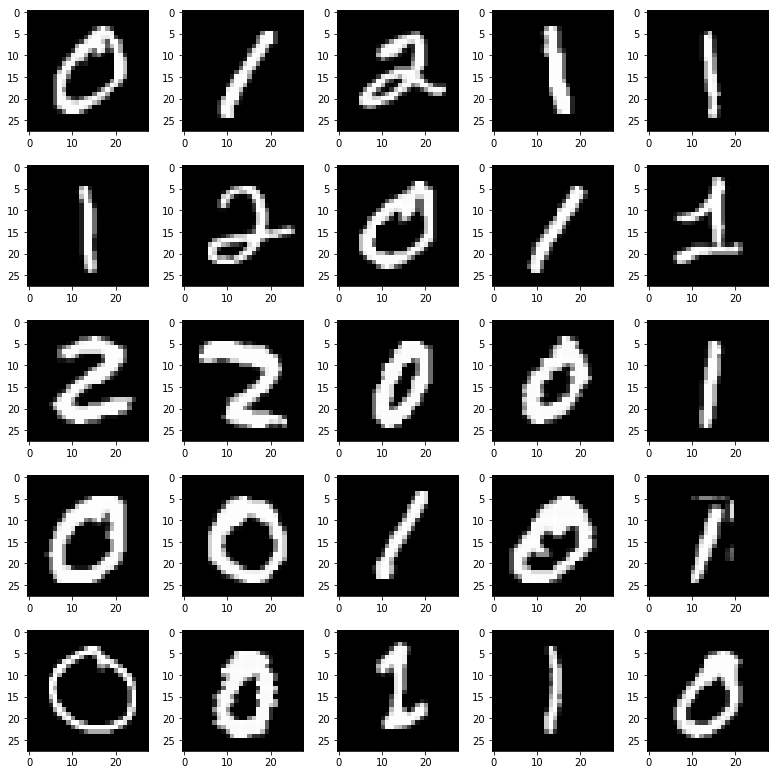

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

In [4]:
def decoder(z):
    model = inf.layers.Sequential([
        tfp.layers.DenseFlipout(28 * 28),
    ])

    return model(z)

In [5]:
# Model constants
k, d = 2, np.shape(x_train)[-1]

@inf.probmodel
def pca(k,d):
    global model_losses
    with inf.datamodel():
        z = inf.Normal(tf.zeros([k]),1, name="z")       # shape = [N,k]
        d = decoder(z)
        x = inf.Normal(d, 1, name="x")         # shape = [N,d]



print(pca)

<function pca at 0x142e6a2f0>


In [6]:
@inf.probmodel
def Q(k,d):
    qw_loc = inf.Parameter(tf.zeros([k,d]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([k,d]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

    qw0_loc = inf.Parameter(tf.ones([d]), name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(tf.ones([d]), name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")
    
    with inf.datamodel():
        qz_loc = inf.Parameter(np.zeros([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(qz_loc, qz_scale, name="z")

print(Q)

<function Q at 0x13bef8b70>


In [7]:
# create an instance of the P model and the Q model
m = pca(k,d)

W1209 08:54:26.918934 4540798400 module_wrapper.py:139] From /Users/jcozar/dev/almeria/inferPy/InferPy/inferpy/models/prob_model.py:63: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1209 08:54:26.990298 4540798400 module_wrapper.py:139] From /Users/jcozar/dev/almeria/inferPy/InferPy/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1209 08:54:27.025048 4540798400 module_wrapper.py:139] From /Users/jcozar/dev/almeria/inferPy/InferPy/inferpy/util/interceptor.py:142: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W1209 08:54:27.154002 4540798400 deprecation.py:323] From /Users/jcozar/dev/almeria/inferPy/InferPy/venv/lib/python3.6/site-packages/tensorflow_probability/python/layers/util.py:102: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instruction

In [8]:
q = Q(k,d)

In [9]:
# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=2000)

In [10]:
m.fit({"x": x_train}, VI)        

W1209 08:54:34.474450 4540798400 deprecation.py:323] From /Users/jcozar/dev/almeria/inferPy/InferPy/inferpy/util/interceptor.py:34: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
W1209 08:54:35.418339 4540798400 deprecation.py:323] From /Users/jcozar/dev/almeria/inferPy/InferPy/venv/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1209 08:54:36.071506 4540798400 module_wrapper.py:139] From /Users/jcozar/dev/almeria/inferPy/InferPy/inferpy/inference/variational/vi.py:187: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.




 0 epochs	 2900831488.0....................
 200 epochs	 2562821888.0....................
 400 epochs	 1924037248.0....................
 600 epochs	 1609520128.0....................
 800 epochs	 1470121600.0....................
 1000 epochs	 1377610368.0....................
 1200 epochs	 1316731904.0....................
 1400 epochs	 1283823488.0....................
 1600 epochs	 1269721472.0....................
 1800 epochs	 1264143232.0....................

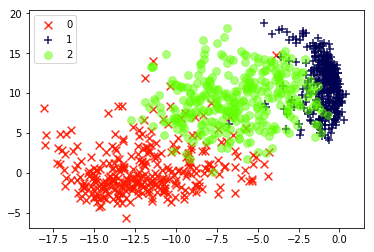

In [11]:
post = {"z": m.posterior("z", data={"x": x_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

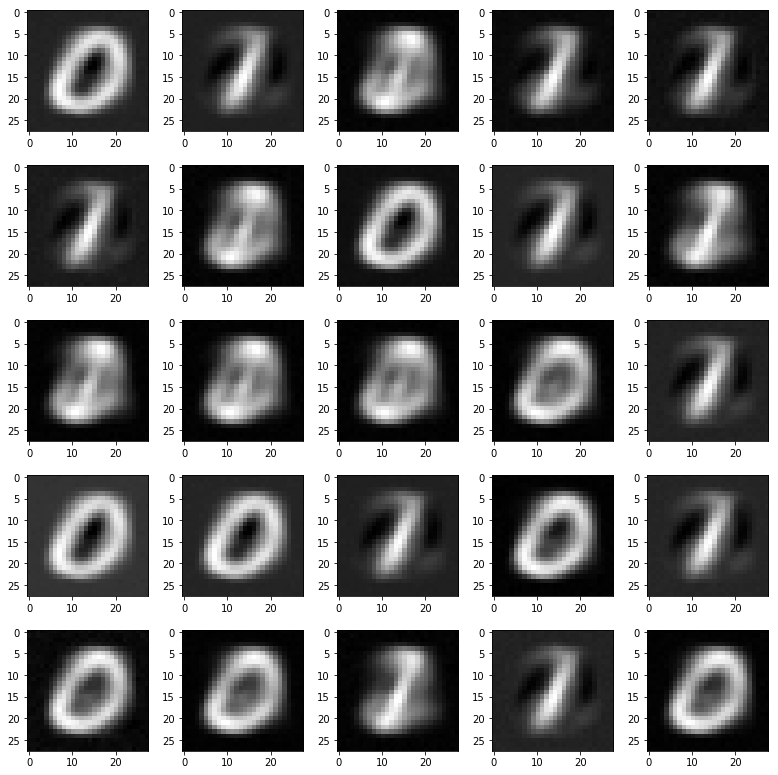

In [12]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])